In [59]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile
import json
from Bio import Align
from Bio.Seq import Seq
import itertools
import scipy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def print_amino_acid_composition(seq:str):
    aas = np.unique(list(seq))
    counts = np.array([seq.count(aa) for aa in aas])
    idxs = np.argsort(counts)[::-1]
    for aa, count in zip(aas[idxs], counts[idxs]):
        print(aa, f'{100 * count / len(seq):.2f}%')

reverse_complement = lambda seq : str(Seq(seq).reverse_complement())



In [61]:
# Several of the spacers from Methanoperedens seem to be targeting scaffolds in the database of putative DPANN scaffolds (<=1 mismatch). 
# However, upon closer inspection, one of the arrays is not a real CRISPR array (ck_bottom_scaffold_10379). 
# The remaining two matched spacers are:
#   (1) SR-VP_05_06_2024_N_top_scaffold_1847_2:4, aligned to SR-VP_05_06_2024_N_middle_scaffold_11254
#   (2) SR-VP_05_06_2024_ck_bottom_scaffold_3220_1:78, aligned to SR-VP_05_06_2024_N_middle_scaffold_11254

# The next question is to figure out what SR-VP_05_06_2024_N_middle_scaffold_11254 belongs to. It has no assigned taxonomy.  
# It seems like it does not actually align to a DPANN Archaeon, and was likely misbinned. It has mostly hypothetical proteins, 
# one of which is annotated as belonging to Methanoperedens (which is the genome in which the CRISPR spacer was identified), 
# and another seemingly belonging to a bacterium. 


# BLAST alignment against sequences from the vernal pool metagenomes shows that it matches
# a high-abundance extrachromosomal element


In [62]:
spacer_scaffold_ids = ['SR-VP_05_06_2024_ck_bottom_scaffold_3220'] # From Methanoperedens. 
spacer_scaffold_ids += ['SR-VP_05_06_2024_N_top_scaffold_1847']
spacer_ids = ['SR-VP_05_06_2024_ck_bottom_scaffold_3220_1:28']
spacer_ids += ['SR-VP_05_06_2024_N_top_scaffold_1847_2:4']

target_scaffold_id = 'SR-VP_05_06_2024_N_middle_scaffold_11254'

# scaffold_to_bin_map = load_scaffold_to_bin_map(cleaned=False)

# Map the new genome names back to the old bin names for compatibility. 
new_bin_id_map = dict()
new_bin_id_map['SR-VP_05_06_2024_N_top_Candidatus_Methanoperedens_Black-host_type_44_27'] = 'SR-VP_05_06_2024_N_top.maxbin2.40'
new_bin_id_map['SR-VP_05_06_2024_ck_bottom_Methanoperedens_44_24'] = 'SR-VP_05_06_2024_ck_bottom.maxbin2.42'

# The target bin has no easily-assignable taxonomy, and seems to be a bit of a mess. 
# https://ggkbase.berkeley.edu/organisms/668036
target_bin_id = 'SR-VP_05_06_2024_N_middle.concoct.40'

In [63]:
spacer_bin_id = 'SR-VP_05_06_2024_N_top.maxbin2.40'
spacer_bin_df = FASTAFile.from_file(f'../data/spacers/orphan/{spacer_bin_id}.orphan_spacers.fa').to_df(parse_description=False)
spacer_seq = spacer_bin_df.loc[spacer_ids[-1]].seq

print(spacer_seq)

ATAATTTATTACGATTACTGACTGATATATCAGG


In [64]:
# SR-VP_05_06_2024_N_middle_scaffold_11254_1 
# https://ggkbase.berkeley.edu/organisms/668036/contigs/1102155721 
# gc_content 25.89 
# length 17736 bp 

# All sequences which align to the target contig have nearly 100 percent identity and query coverage, 
# so almost certainly contain the spacer. 

# Two of the hits are to Final_SR-VP_05_06_2024_coassembly_19kb_linear_ECE_26_1334_complete 

In [65]:
ece_id = 'Final_SR-VP_05_06_2024_coassembly_19kb_linear_ECE_26_1334_complete'
ece_id = 'ece_26_1334'
GenBankFile.from_file(f'../data/{ece_id}.gbk').to_fasta(f'../data/{ece_id}_protein.fa')

In [66]:
ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()

coordinate_pattern = r'(\d+)..(\d+)'
ece_df['start'] = [int(re.search(coordinate_pattern, coordinate).group(1)) for coordinate in ece_df.coordinate]
ece_df['stop'] = [int(re.search(coordinate_pattern, coordinate).group(2)) for coordinate in ece_df.coordinate]
ece_df['stop_codon'] = [ece_seq[stop - 3:stop] for stop in ece_df.stop]
ece_df['strand'] = np.where(ece_df.coordinate.str.contains('comp'), '-', '+')
ece_df['position'] = np.arange(len(ece_df))

ece_df['seq'] = ece_df.seq.str.replace('*', '', regex=False)
ece_df['nt_seq'] = [ece_seq[start - 1:stop] for start, stop in zip(ece_df.start, ece_df.stop)]
ece_df['nt_seq'] = [reverse_complement(row.nt_seq) if (row.strand == '-') else row.nt_seq for row in ece_df.itertuples()] # Reverse complement if on the opposite strand. 

In [67]:
def load_proteins_with_nucleotide_sequences(genome_id, proteins_dir='../data/proteins'):
    df = FASTAFile.from_file(os.path.join(proteins_dir, f'{genome_id}.fa')).to_df()
    df['strand'] = np.where(df.strand == -1, '-', '+')
    df['seq'] = df.seq.str.replace('*', '', regex=False)
    fn_fasta_file = FASTAFile.from_file(os.path.join('../data/genomes', f'{genome_id}.fn'))
    df['nt_seq'] = [fn_fasta_file.get_seq(row.contig_id, start=row.start - 1, stop=row.stop, strand=row.strand) for row in df.itertuples()]
    return df

In [68]:
nts = 'ATCGN'
aas = 'ACDEFGHIKLMNPQRSTVWYX'

def get_codons(nt_seq):
    nt_seq = nt_seq[3:-3] # Remove the stop codon and start codon. 
    codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq), 3)])
    return codons

# Multiple codons code for the same amino acid... probably want to compare the codon usage distribution for each amino acid, not the overall 
# codon usage, or it will just be biased according to which amino acids are the most common. Although I would think that GC content also affects which amino
# acids are used in a protein. 
def _get_codon_usage(aa_seq, nt_seq, codon_usage:dict=None):

    codons = get_codons(nt_seq)
    amino_acids = np.array(list(aa_seq))[1:] # Because we are ignoring the start codon. 

    assert len(codons) == len(amino_acids), f'get_codon_usage: Number of codons and number of amino acids should match, {len(codons)} != {len(amino_acids)}'
    mask = np.array([(codon.count('N') == 0) for codon in codons]) & (amino_acids != 'X') # Ignore anything unknown. 
    for aa, codon in zip(amino_acids[mask], codons[mask]):
        codon_usage[str(aa)].append(str(codon))
    # return codon_usage


def check_codon_usage(codon_usage):
    codons = list()
    for aa, aa_codons in codon_usage.items():
        aa_codons = np.unique(aa_codons)
        # aa_codons_already_seen = aa_codons[np.isin(aa_codons, codons)]
        assert not np.any(np.isin(aa_codons, codons)), f'check_codon_usage: Already encountered a codon used for {aa}'
        codons += aa_codons.tolist()
    print(f'check_codon_usage: {len(codons)} total codons encountered.')


def get_codon_usage(df:pd.DataFrame):   
    # df = df[df.partial == '00'].copy()
    df = df[(df.nt_seq.apply(len) % 3) == 0].copy()
    df['seq'] = df['seq'].str.replace('*', '', regex=False)
    codon_usage = {aa:list() for aa in aas}
    for aa_seq, nt_seq in zip(df.seq, df.nt_seq):
        # assert len(nt_seq) % 3 == 0, 'get_codon_usage: Length of nucleotide sequence {nt_seq} is not divisible by three.'
        try:
            _get_codon_usage(aa_seq, nt_seq, codon_usage=codon_usage)
        except:
            pass
    check_codon_usage(codon_usage)
    return codon_usage



In [69]:
codon_usage = dict()
codon_usage[ece_id] = get_codon_usage(ece_df)

host_genome_ids = ['SR-VP_05_06_2024_N_top_Candidatus_Methanoperedens_Black-host_type_44_27', 'SR-VP_05_06_2024_ck_bottom_Methanoperedens_44_24']
for genome_id in host_genome_ids:
    codon_usage[genome_id] = get_codon_usage(load_proteins_with_nucleotide_sequences(genome_id))

check_codon_usage: 61 total codons encountered.
check_codon_usage: 61 total codons encountered.
check_codon_usage: 61 total codons encountered.


In [70]:
# Do any specific genes on the ECE have codon usage that matches the reference?

def get_codon_distribution(codon_usage):
    # Need to make sure to control for amino acid frequencies, so do this on a residue-by-residue basis. 
    codon_dist = dict()
    # max_codon_dist = dict()
    for aa, codons in codon_usage.items():
        codons, counts = np.unique(codons, return_counts=True)
        frequencies = counts / counts.sum()
        codon_dist.update(dict(zip(codons, frequencies)))
        # max_codon_dist[aa] = max(frequencies)
    return codon_dist

codon_dist = get_codon_distribution(codon_usage[host_genome_ids[0]])

def get_likelihood(nt_seq, codon_dist=codon_dist):
    codons = [codon for codon in get_codons(nt_seq) if ('N' not in codon)]
    probabilities = [codon_dist[codon] for codon in codons]
    return (-np.log(probabilities)).mean() # Use the mean to control for sequence length. 


ece_df['score'] = ece_df.nt_seq.apply(get_likelihood)
host_dfs = {genome_id:load_proteins_with_nucleotide_sequences(genome_id) for genome_id in host_genome_ids}
host_dfs = {genome_id:host_df.assign(score=host_df.nt_seq.apply(get_likelihood)) for genome_id, host_df in host_dfs.items()}

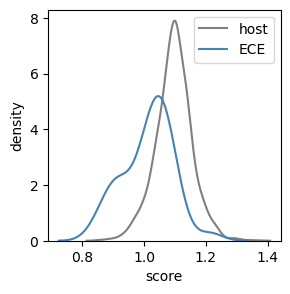

In [71]:
fig, ax = plt.subplots(figsize=(3, 3))
for genome_id, host_df in host_dfs.items():
    sns.kdeplot(host_df, x='score', label='host', color='gray')
    break
sns.kdeplot(ece_df, x='score', color='steelblue', label='ECE')
ax.set_ylabel('density')
ax.legend()
plt.show()

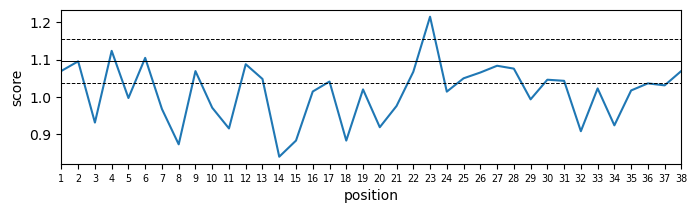

In [72]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.lineplot(ece_df, x='position', y='score')
# ax.axvline(22, ls='--', color='black', lw=0.7)
ax.set_xticks(np.arange(len(ece_df)), labels=np.arange(len(ece_df)) + 1, fontsize='x-small')

mean = host_dfs[host_genome_ids[0]].score.mean()
std = host_dfs[host_genome_ids[0]].score.std()
ax.axhline(mean, color='black', lw=0.7)
ax.axhline(mean + std, color='black', lw=0.7, ls='--')
ax.axhline(mean - std, color='black', lw=0.7, ls='--')

ax.set_xlim(xmin=0, xmax=37)
plt.show()

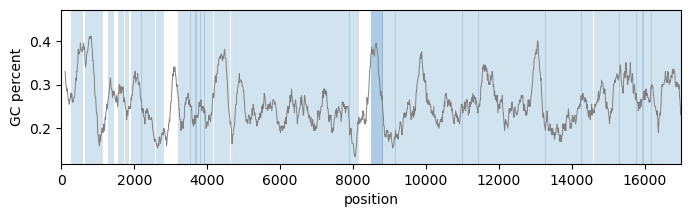

In [73]:
window_size = 200
figure_df = list()
for position in range(window_size // 2, len(ece_seq) - window_size // 2, 10):
    sub_seq = ece_seq[position - window_size // 2: position + window_size // 2]
    gc_content = (sub_seq.count('G') + sub_seq.count('C')) / len(sub_seq)
    figure_df.append({'gc_content':gc_content, 'position':position})
figure_df = pd.DataFrame(figure_df)

fig, ax = plt.subplots(figsize=(8, 2))
sns.lineplot(figure_df, x='position', y='gc_content', color='gray', lw=0.7)

for row in ece_df.itertuples():
    if (row.position + 1) == 23:
        ax.axvspan(row.start, row.stop, alpha=0.2, lw=0.5, edgecolor='steelblue')
    ax.axvspan(row.start, row.stop, alpha=0.2, lw=0.5, edgecolor='steelblue')
ax.set_xlim(xmin=0, xmax=17000)
ax.set_ylabel('GC percent')
plt.show()



In [74]:
# for aa in list(aas):

#     expected = np.array(codon_usage[host_genome_ids[0]][aa])
#     observed = np.array(codon_usage[ece_id][aa])
#     if (len(expected) == 0) or (len(observed) == 0):
#         continue
#     alphabet = np.unique(np.concatenate([expected, observed]), axis=0)
#     expected = np.array([(codon == expected).sum() for codon in alphabet]) # / len(expected)
#     observed = np.array([(codon == observed).sum() for codon in alphabet])#  / len(observed)
#     table = np.vstack([observed, expected])

#     chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False) 


In [75]:
protein_38_start, protein_38_stop = ece_df.loc['ece_26_1334_38'].start - 1, ece_df.loc['ece_26_1334_38'].stop
protein_1_start, protein_1_stop = ece_df.loc['ece_26_1334_1'].start - 1, ece_df.loc['ece_26_1334_1'].stop

print(ece_seq[protein_1_start:protein_1_stop])
print(reverse_complement(ece_seq[protein_38_start:protein_38_stop]))
ece_df = ece_df[ece_df.index != 'ece_26_1334_38'].copy()

ATGAAAGAAATTAAGAAAGTAACTTCAATAAAGGTTTATCCTTCATTAATAAATCGAGCCAAAATAAAAGCAGTAGAGCAGGGAATAACATTAAGTGAACTGATAGAAAAAGCAATAGATAATATAACAAAAACAGAACAGATTTTATTATCAGGTGATGAAATTTCAGAGTTTCTATCATCAAAGAATGATGTAAAGCACGGCTTCAAATACAAAGGTGTGGTCTATCAGGATAAGAGTATAGCCGAAATGAAGCAGGACTTTGATGCGGCTACAGGTGCGGGGAGTGAGGGATAA
ATGAAAGAAATTAAGAAAGTAACTTCAATAAAGGTTTATCCTTCATTAATAAATCGAGCCAAAATAAAAGCAGTAGAGCAGGGAATAACATTAAGTGAACTGATAGAAAAAGCAATAGATAATATAACAAAAACAGAACAGATTTTATTATCAGGTGATGAAATTTCAGAGTTTCTATCATCAAAGAATGATGTAAAGCACGGCTTCAAATACAAAGGTGTGGTCTATCAGGATAAGAGTATAGCCGAAATGAAGCAGGACTTTGATGCGGCTACAGGTGCGGGGAGTGAGGGATAA


In [76]:
def get_alignment_length(alignment):
    idxs = alignment.aligned[0]
    return sum([stop - start for start, stop in idxs])

def get_pairwise_similarity(fa_df:pd.DataFrame):
    aligner = Align.PairwiseAligner()
    # similarity_df = pd.DataFrame(index=fa_df.index, columns=fa_df.index)
    # for id_a, id_b in itertools.product(fa_df.index, fa_df.index):
    #     seq_a, seq_b = fa_df.loc[id_a].seq, fa_df.loc[id_b].seq
    #     alignment = aligner.align(seq_a, seq_b)[0]
    #     similarity_df.loc[id_a, id_b] = alignment.score / get_alignment_length(alignment)
    # similarity_df[similarity_df < 0] = 0
    # return similarity_df
    similarity_df = list()
    for id_a, id_b in itertools.combinations(fa_df.index, 2):
        seq_a, seq_b = fa_df.loc[id_a].seq, fa_df.loc[id_b].seq
        alignment = aligner.align(seq_a, seq_b)[0]
        similarity = alignment.score / get_alignment_length(alignment)
        similarity_df.append({'id_a':id_a, 'id_b':id_b, 'similarity':similarity, 'alignment_length':get_alignment_length(alignment)})
    return pd.DataFrame(similarity_df)

similarity_df = get_pairwise_similarity(ece_df)
similarity_df = similarity_df[(similarity_df.similarity > 0.15)].copy()
similarity_df.sort_values('similarity', ascending=False)

,id_a,id_b,similarity,alignment_length
5,ece_26_1334_1,ece_26_1334_7,0.191489,94
350,ece_26_1334_12,ece_26_1334_22,0.176471,68
113,ece_26_1334_4,ece_26_1334_13,0.170213,47
235,ece_26_1334_8,ece_26_1334_13,0.162791,43
344,ece_26_1334_12,ece_26_1334_16,0.156250,64
589,ece_26_1334_25,ece_26_1334_27,0.153979,578


In [77]:
def align(seq_a, seq_b):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.mismatch_score = 0
    alignment = aligner.align(seq_a, seq_b)[0]
    print(alignment)

align(ece_df.loc['ece_26_1334_25'].seq, ece_df.loc['ece_26_1334_27'].seq)


target           22 ISANAQQNYSLNQPLKEISFNKWSMNISFPNVMSYISLKNAIQNDSNSNII-WNLSLIYG
                  0 |.......|.....|..|-|.............|.......|..|.|.|..-|..|....
query             9 IITGKYKTYHRLWILSLI-FILIFNPLHAKADWSDNFNGGSISGDWNVNSGAWDASSTHL

target           81 QTYILSASLKNYNQKSNLLCSHCS-TWYL-NGSWEIIEVYNISNPCLNCIVNYSGSFNKS
                 60 .......|.......|....|...-|.|.-|....|.|...........|.....|..-|
query            68 NATLGDMSEIANITHSLGNFSIFNFTYYGRNVPTSITEDDFLRWSNGHNIFTFRHSGV-S

target          139 DRWINTTTFTD-IP-FWNESNI-VYINLTNNDSQIGKAINNSNSYTSASNGITTFNIFTS
                120 |..|.......-|.-|......-|..||.....|.|......|...|..||....|.-||
query           127 DGLISIVSELPSIGTFYIADHTEVNFNLKFDTFQVGNSSTKFNLFVSYPNGSIIINK-TS

target          196 TEISNYVSGLILKNTGGYVYRASVTTPTAEVMEFGFGDSATRYPTNSIEVETYTQAPVQY
                180 ....|..-|.|...|....|...-|........|...........|.|.....|-|....
query           186 VYDINTL-GVIGDLTLLESYNMG-TWDRFYYDNFQVIMNPSISMENAIITTDKT-AYNLG

target          256 EINM

In [78]:
# foldseek easy-search ./data/ /shared/db/foldseek/latest/db/pdb  ece_26_1334_pdb_foldseek.tsv  tmp --format-mode 4  --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage  --threads 64
# foldseek easy-search ./data/ /shared/db/foldseek/latest/db/alphafold_esmatlas30  ece_26_1334_alphafold_esmatlas30.tsv  tmp --format-mode 4  --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage  --threads 64
# foldseek easy-search ./data/ /shared/db/foldseek/latest/db/alphafold_uniprot  ece_26_1334_uniprot.tsv  tmp --format-mode 4  --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage  --threads 64

get_protein_number = lambda protein_id : int(re.search(rf'{ece_id}_complete_(\d+)', protein_id).group(1))
dest_dir = '../data/biotite' # Dump all relevant models into this folder to port over to biotite. 
for i, path in enumerate(sorted(glob.glob('../data/alphafold/*/*model_0.cif'), key=get_protein_number)):
    file_name = f'{ece_id}_{i + 1}_model_0.cif'
    dest_path = os.path.join(dest_dir, file_name)
    if not os.path.exists(dest_path):
        subprocess.run(f'cp {path} {dest_path}', shell=True, check=True)


In [79]:
interproscan_df = InterProScanFileTSV.from_file(f'../data/{ece_id}_interproscan.tsv').to_df()
interproscan_df = interproscan_df[interproscan_df.signature_analysis != 'MobiDBLite'].copy() # Don't trust any of these. 
print('Num. proteins with InterProScan hits:', interproscan_df['id'].nunique())

has_signal_peptide = lambda df : df.signature_accession.str.contains('signal|SignalP', regex=True, case=False).sum() > 0 
has_transmembrane_helix = lambda df : df.signature_accession.str.contains('transmembrane|TMhelix', case=False).sum() > 0 

ids = interproscan_df.groupby('id')['id'].first()
ids_with_signal_peptide = ids[interproscan_df.groupby('id').apply(has_signal_peptide, include_groups=False)]
ids_with_transmembrane_helix = ids[interproscan_df.groupby('id').apply(has_transmembrane_helix, include_groups=False)]

print('Num. proteins with potential signal peptides:', len(ids_with_signal_peptide))
print('Num. proteins with potential transmembrane helices:', len(ids_with_transmembrane_helix))

Num. proteins with InterProScan hits: 14
Num. proteins with potential signal peptides: 7
Num. proteins with potential transmembrane helices: 11


In [ ]:
# Protein 25 is particularly weird, it AS A INGTNGI repeat; N is Arginine, T is Tryptophan, I is Isoleucine. 
# Seems to align to polyketide synthases, but seems far too short. Appears to be a linker loop thing (450-500) in between two high-confidence
# beta sheet structures in the AlphaFold structure. One of the regions flanking the linker domain (350-450) is a Carboxypeptidase. 
# Nearly the entire protein is predicted to be extracellular. 

# Residues 300-600 seem like they may nominally resemble BamB, which is a much shorter protein. 

# Honestly the whole N-terminus of the protein looks like absolute garbage. Possible frameshift? What is protein 24?
# There are alternate start codons which could N-terminally truncate Protein 25 and make it closer in size to other proteins involved in outer membrane
# construction; selecting the ATG at position 300 results in a similar AlphaFold structure, though the signal peptide is lost. It seems likely
# that the selected start site is correct. 


# https://www.nature.com/articles/s41589-025-01878-4 about polyketide synthase. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC8338781/ about polyketide synthase. 
